# Integration of blocksworld simulator with VLM predicate extraction

The goal here is to use the simulator we have and the planner, but then use the VLM to actually verify the preconditions and effects of actions. For now, let's assume that the initial state is known and that the actions never fail, so the only failure point is the VLM.

In [1]:
import os
import sys

ROOT = os.path.dirname(os.path.dirname(os.path.abspath('.')))
print("ROOT", ROOT)

ROOT /scratch/cs/world-models/merlerm1/open-world-symbolic-planner


In [2]:
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ":4096:8"

In [3]:
sys.path.append(ROOT)

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from unified_planning.shortcuts import *
from unified_planning.io import PDDLReader

from PIL import Image
import matplotlib.pyplot as plt

from viplan.planning.blocksworld_simulator import BlocksworldSimulator
from viplan.code_helpers import get_logger

In [6]:
def plot_image(img):
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [7]:
DOMAIN_FILE = os.path.join(ROOT, 'data', 'planning', 'bird-blocksworld', 'domain.pddl')
PROBLEM_FILE = os.path.join(ROOT, 'data', 'planning', 'bird-blocksworld', 'test_problem_3.pddl')

reader = PDDLReader()
problem = reader.parse_problem(DOMAIN_FILE, PROBLEM_FILE)

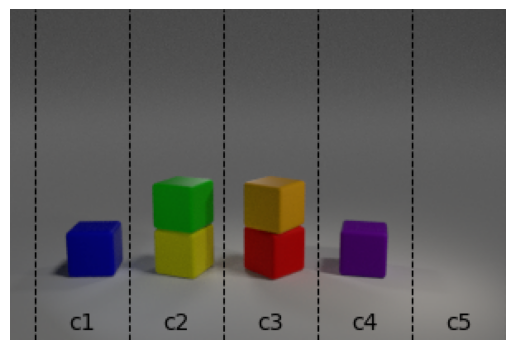

In [8]:
logger = get_logger(log_level='info')
env = BlocksworldSimulator(problem, root_path=ROOT, logger=logger, seed=1)
plot_image(env.render())

In [9]:
with OneshotPlanner(problem_kind=problem.kind) as planner:
    result = planner.solve(problem)
    if result.status == up.engines.PlanGenerationResultStatus.SOLVED_SATISFICING:
        print("Fast Downward returned: %s" % result.plan)
    else:
        print("No plan found.")

NOTE: To disable printing of planning engine credits, add this line to your code: `up.shortcuts.get_environment().credits_stream = None`
  *** Credits ***
  * In operation mode `OneshotPlanner` at line 1 of `/tmp/ipykernel_1292242/4173542664.py`, you are using the following planning engine:
  * Engine name: Fast Downward
  * Developers:  Uni Basel team and contributors (cf. https://github.com/aibasel/downward/blob/main/README.md)
  * Description: Fast Downward is a domain-independent classical planning system.

Fast Downward returned: SequentialPlan:
    moveblock(p, c1)
    moveblock(g, c5)
    moveblock(y, c4)
    moveblock(p, c4)
    moveblock(o, c2)
    moveblock(r, c1)
    moveblock(r, c5)
    moveblock(b, c3)
    moveblock(r, c1)


At this point, we need to apply the first action of the plan. First, we check the preconditions, and if they are satisfied, we execute the action and check the effects. For now, let's just extract the questions we need to ask the VLM and use a mock VLM to answer them (for faster prototyping).

## Extracting predicates from actions

In [10]:
def get_predicates_for_question(node, grounded_args, top_level=True, default_value=True):
    result = []
 
    if not node.is_fluent_exp():
        
        if node.is_not():
            child = node.args[0]
            exps = get_predicates_for_question(child, grounded_args, False)
            if len(exps) > 1:
                raise NotImplementedError("Not implemented for multiple expressions")
            for key, value in exps[0].items():
                result.append({key: not value})
        else:
            for child in node.args:
                exps = get_predicates_for_question(child, grounded_args, False)
                result.extend(exps)

    elif node.is_fluent_exp():
        fluent_name = node.fluent().name
        arg_names = [str(arg) for arg in node.args]
        actual_args = [str(grounded_args[arg]) for arg in arg_names]
        args_key = ",".join(actual_args)
        key = fluent_name + " " + args_key
        value = default_value # by default assume precondition is asking for predicate to be default_value (for effects it can also be False)
        # print("Fluent", fluent_name, arg_names, value)
        bool_value = value if isinstance(value, bool) else value.is_true()
        result = {key: bool_value}

    else:
        raise ValueError("Unknown node type", node)

    return [result] if type(result) is dict else result

In [11]:
def get_preconditions_predicates(preconditions, grounded_args):
    preconditions_predicates = []
    for precondition in preconditions:
        preds = get_predicates_for_question(precondition, grounded_args)
        preconditions_predicates.extend(preds)
    return preds

In [12]:
action = result.plan.actions[0]
grounded_args = {param.name: str(value) for param, value in zip(action.action.parameters, action.actual_parameters)}
print("Grounded args:", grounded_args)
preconditions = action.action.preconditions
print("Preconditions:", preconditions)
preconditions_predicates = get_preconditions_predicates(preconditions, grounded_args)
print("Preconditions predicates:", preconditions_predicates)

Grounded args: {'b1': 'p', 'c1': 'c1'}
Preconditions: [(clear(b1) and (not incolumn(b1, c1)))]
Preconditions predicates: [{'clear p': True}, {'incolumn p,c1': False}]


For the questions about the preconditions, we should be fine with these. For the effects however, we also need to consider forall and conditionals, which need to operate on the previous state (i.e. the state before the action was executed), so we need an extra wrapper.

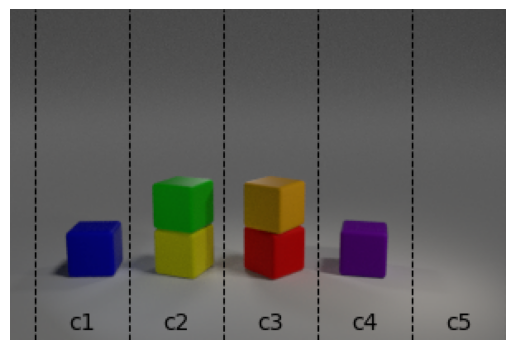

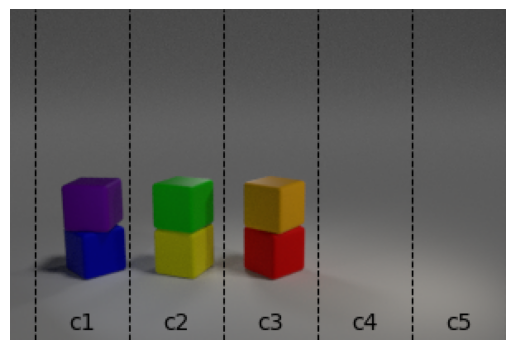

In [13]:
import copy

env.reset()
previous_state = copy.deepcopy(env.state)
plot_image(env.render())
env.apply_action(action)
plot_image(env.render())
state = copy.deepcopy(env.state)

In [14]:
def get_effect_predicates(env, effect, grounded_args, previous_state):
    """
    Applies effect to the state.
    For non-conditional effects, it uses get_predicates_for_question to extract predicates from the fluent.
    For conditional effects, it checks the condition using env.check_value on previous_state.
    Returns a list of predicates gathered from the effect applications.
    """
    all_preds = []

    if effect.is_forall():
        assert len(effect.forall) == 1, "Only single forall supported"
        var = effect.forall[0]
        for value in env.all_objects[str(var.type)]:
            grounded_args[var.name] = str(value)
            if effect.is_conditional():
                condition = effect.condition
                # For conditional effects, use the previous state.
                # print(f"Checking condition {condition} for {effect.fluent} with {grounded_args}")
                # print(f"Condition value: {env._check_value(condition, grounded_args, previous_state)}")
                if not env._check_value(condition, grounded_args, previous_state):
                    continue
            # Get list of predicates from the fluent using get_predicates_for_question.
            # print("Forall", effect.fluent, grounded_args)
            preds = get_predicates_for_question(effect.fluent, grounded_args, top_level=False, default_value=effect.value)
            # Ensure we work with a list.
            # print(f"Adding predicates {preds} for {effect.fluent} with {grounded_args}")
            if isinstance(preds, dict):
                all_preds.append(preds)
            else:
                all_preds.extend(preds)

    elif effect.is_conditional():
        condition = effect.condition
        # For conditional effects, check condition against previous_state.
        if env._check_value(condition, grounded_args, previous_state):
            # print("Conditional", effect.fluent, grounded_args)
            preds = get_predicates_for_question(effect.fluent, grounded_args, top_level=False, default_value=effect.value)
            if isinstance(preds, dict):
                all_preds.append(preds)
            else:
                all_preds.extend(preds)

    else:
        # print("Simple", effect.fluent, grounded_args)
        preds = get_predicates_for_question(effect.fluent, grounded_args, top_level=False, default_value=effect.value)
        if isinstance(preds, dict):
            all_preds.append(preds)
        else:
            all_preds.extend(preds)

    return all_preds

def get_effects_predicates(env, effects, grounded_args, previous_state):
    all_preds = []
    for effect in effects:
        preds = get_effect_predicates(env, effect, grounded_args, previous_state)
        all_preds.extend(preds)
    return all_preds

In [15]:
effects = action.action.effects
# for effect in effects:
#     print(effect)
get_effects_predicates(env, effects, grounded_args, previous_state)

[{'incolumn p,c1': True},
 {'clear p': True},
 {'incolumn p,c4': False},
 {'on p,b': True},
 {'clear b': False}]

Perfect, so these can act as questions (the predicates), as well as the expected answer. 

## Replanning when preconditions are not met

Let's first define a difference between the "environment state" (i.e. the ground truth of what is actually in the environment) and the "VLM state", which is what the VLM thinks is in the environment. Initially these will be the same, but if the VLM fails these will diverge.

In [16]:
env.reset()
vlm_state = copy.deepcopy(env.state)
state = copy.deepcopy(env.state)
vlm_state

{'on': defaultdict(<function viplan.planning.blocksworld_simulator.BlocksworldSimulator._init_state_from_problem.<locals>.<lambda>(*arg_names)>,
             {'g,y': True,
              'o,r': True,
              'r,r': False,
              'g,r': False,
              'b,r': False,
              'y,r': False,
              'p,r': False,
              'r,g': False,
              'g,g': False,
              'b,g': False,
              'y,g': False,
              'o,g': False,
              'p,g': False,
              'r,b': False,
              'g,b': False,
              'b,b': False,
              'y,b': False,
              'o,b': False,
              'p,b': False,
              'r,y': False,
              'b,y': False,
              'y,y': False,
              'o,y': False,
              'p,y': False,
              'r,o': False,
              'g,o': False,
              'b,o': False,
              'y,o': False,
              'o,o': False,
              'p,o': False,
              'r,

If a precondition is not met (i.e. the VLM fails to detect it properly) what we need to do is take the VLM state, edit it with what the VLM has observed and regenerate a new PDDL problem based on the new VLM state, and then recall the planner on it.

In [17]:
def mock_precondition_error(preconditions, grounded_args, state, vlm_state, index):
    precondition_preds = get_preconditions_predicates(preconditions, grounded_args)
    print("Precondition preds:", precondition_preds)

    # Mock an error in detection
    for key in precondition_preds[index]:
        precondition_preds[index][key] = not precondition_preds[index][key]

    print("Precondition preds with error:", precondition_preds)

    for pred in precondition_preds:
        key = list(pred.keys())[0]
        predicate = key.split(" ")[0]
        args = key.split(" ")[1:]
        args_key = ",".join(args)
        if predicate not in vlm_state:
            raise ValueError(f"Predicate {predicate} not found in vlm_state")
        if pred[key] != vlm_state[predicate][args_key]:
            print("Switching predicate", predicate, args, args_key)
            vlm_state[predicate][args_key] = pred[key]

mock_precondition_error(preconditions, grounded_args, state, vlm_state, 0)

Precondition preds: [{'clear p': True}, {'incolumn p,c1': False}]
Precondition preds with error: [{'clear p': False}, {'incolumn p,c1': False}]
Switching predicate clear ['p'] p


In [18]:
def update_problem(state, problem):
    
    def get_new_problem_fluent(new_problem, fluent):
        for new_fluent in new_problem.initial_values:
            if str(new_fluent) == str(fluent):
                return new_fluent
        return None
       
    new_problem = copy.deepcopy(problem)
    
    for fluent in problem.initial_values:
        
        name = fluent.fluent().name
        args = fluent.args
        args_str = ",".join([str(arg) for arg in args])
        value = problem.initial_values[fluent].is_true()
        state_value = state[name][args_str]
        if value != state_value:
            # print(f"Found discrepancy for {name} {args_str}: VLM saw {state_value}, PDDL expects {value}")
            assert problem.initial_values[fluent].is_bool_constant()
            new_fluent = get_new_problem_fluent(new_problem, fluent)
            if new_fluent is None:
                raise ValueError(f"Fluent {fluent} not found in new_problem")
            
            new_problem.initial_values[new_fluent] = problem.initial_values[fluent].__invert__().simplify()
            
    return new_problem
    
new_problem = update_problem(vlm_state, problem)
new_problem

problem name = unstack-blocks-purple

types = [block, column]

fluents = [
  bool on[b1=block, b2=block]
  bool incolumn[b=block, c=column]
  bool clear[b=block]
  bool rightof[c1=column, c2=column]
  bool leftof[c1=column, c2=column]
]

actions = [
  action moveblock(block b1, column c1) {
    preconditions = [
      (clear(b1) and (not incolumn(b1, c1)))
    ]
    effects = [
      incolumn(b1, c1) := true
      clear(b1) := true
      forall column c2 if incolumn(b1, c2) then incolumn(b1, c2) := false
      forall block b2 if on(b1, b2) then on(b1, b2) := false
      forall block b2 if on(b1, b2) then clear(b2) := true
      forall block b2 if (incolumn(b2, c1) and clear(b2) and (not (b2 == b1))) then on(b1, b2) := true
      forall block b2 if (incolumn(b2, c1) and clear(b2) and (not (b2 == b1))) then clear(b2) := false
    ]
  }
]

objects = [
  block: [r, g, b, y, o, p]
  column: [c1, c2, c3, c4, c5]
]

initial fluents default = [
  bool on[b1=block, b2=block] := false
  bool inc

In [19]:
with OneshotPlanner(problem_kind=new_problem.kind) as planner:
    result = planner.solve(new_problem)
    if result.status == up.engines.PlanGenerationResultStatus.SOLVED_SATISFICING:
        print("Fast Downward returned: %s" % result.plan)
    else:
        print("No plan found.")

  *** Credits ***
  * In operation mode `OneshotPlanner` at line 1 of `/tmp/ipykernel_1292242/3634134506.py`, you are using the following planning engine:
  * Engine name: Fast Downward
  * Developers:  Uni Basel team and contributors (cf. https://github.com/aibasel/downward/blob/main/README.md)
  * Description: Fast Downward is a domain-independent classical planning system.

No plan found.


This makes sense: if purple is not clear now there will never be an action that will make it clear (since there are no blocks on top of it) and no plan is found.

Let's try a different mistake instead:

In [20]:
vlm_state = copy.deepcopy(env.state)

mock_precondition_error(preconditions, grounded_args, state, vlm_state, 1)

Precondition preds: [{'clear p': True}, {'incolumn p,c1': False}]
Precondition preds with error: [{'clear p': True}, {'incolumn p,c1': True}]
Switching predicate incolumn ['p,c1'] p,c1


In [21]:
new_problem = update_problem(vlm_state, problem)

with OneshotPlanner(problem_kind=new_problem.kind) as planner:
    result = planner.solve(new_problem)
    if result.status == up.engines.PlanGenerationResultStatus.SOLVED_SATISFICING:
        print("Fast Downward returned: %s" % result.plan)
    else:
        print("No plan found.")

  *** Credits ***
  * In operation mode `OneshotPlanner` at line 3 of `/tmp/ipykernel_1292242/1641642495.py`, you are using the following planning engine:
  * Engine name: Fast Downward
  * Developers:  Uni Basel team and contributors (cf. https://github.com/aibasel/downward/blob/main/README.md)
  * Description: Fast Downward is a domain-independent classical planning system.

Fast Downward returned: SequentialPlan:
    moveblock(o, c2)
    moveblock(o, c5)
    moveblock(g, c5)
    moveblock(y, c4)
    moveblock(g, c4)
    moveblock(o, c2)
    moveblock(b, c3)
    moveblock(b, c5)
    moveblock(g, c5)
    moveblock(y, c2)
    moveblock(r, c1)
    moveblock(y, c4)
    moveblock(g, c4)
    moveblock(b, c3)
    moveblock(r, c5)
    moveblock(g, c5)
    moveblock(g, c4)
    moveblock(r, c1)
    moveblock(g, c5)
    moveblock(p, c2)
    moveblock(p, c4)


In this case a new plan (although pretty long and inconsistent for some reason) is found, since mistakingly believing the block was in another column could be fixed.

### Get questions from predicates

In [22]:
predicate_questions = {
    'on': 'Is the {b1} on top of the {b2}?',
    'clear': 'Is the {b} the topmost of its column?',
    'incolumn': 'Is the {b} in the {c}?',
    'rightof': 'Is the {c1} to the right of the {c2}?',
    'leftof': 'Is the {c1} to the left of the {c2}?',
}

block_templates = {
    'r': 'red block',
    'g': 'green block',
    'b': 'blue block',
    'y': 'yellow block',
    'o': 'orange block',
    'p': 'purple block',
}

column_templates = {
    'c1': 'column labeled "c1"',
    'c2': 'column labeled "c2"',
    'c3': 'column labeled "c3"',
    'c4': 'column labeled "c4"',
    'c5': 'column labeled "c5"',
} 

In [23]:
def get_questions(predicates, block_templates, column_templates):
    questions = {}
    
    for pred in predicates:
        key = list(pred.keys())[0]
        predicate = key.split(" ")[0]
        value = pred[key]
        args = key.split(" ")[1].split(",")
        
        if predicate == 'on':
            b1 = block_templates[args[0]]
            b2 = block_templates[args[1]]
            questions[predicate + " " + ",".join(args)] = (predicate_questions[predicate].format(b1=b1, b2=b2), value)
        elif predicate == 'clear':
            b = block_templates[args[0]]
            questions[predicate + " " + ",".join(args)] = (predicate_questions[predicate].format(b=b), value)
        elif predicate == 'incolumn':
            b = block_templates[args[0]]
            c = column_templates[args[1]]
            questions[predicate + " " + ",".join(args)] = (predicate_questions[predicate].format(b=b, c=c), value)
        elif predicate == 'rightof':
            c1 = column_templates[args[0]]
            c2 = column_templates[args[1]]
            questions[predicate + " " + ",".join(args)] = (predicate_questions[predicate].format(c1=c1, c2=c2), value)
        elif predicate == 'leftof':
            c1 = column_templates[args[0]]
            c2 = column_templates[args[1]]
            questions[predicate + " " + ",".join(args)] = (predicate_questions[predicate].format(c1=c1, c2=c2), value)
        else:
            raise ValueError(f"Unknown predicate {predicate}")
    
    return questions


In [24]:
preconditions = action.action.preconditions
precondition_preds = get_preconditions_predicates(preconditions, grounded_args)
print(precondition_preds)
questions = get_questions(precondition_preds, block_templates, column_templates)
questions

[{'clear p': True}, {'incolumn p,c1': False}]


{'clear p': ('Is the purple block the topmost of its column?', True),
 'incolumn p,c1': ('Is the purple block in the column labeled "c1"?', False)}

In [25]:
effects = action.action.effects
effect_preds = get_effects_predicates(env, effects, grounded_args, previous_state)
print(effect_preds)
questions = get_questions(effect_preds, block_templates, column_templates)
questions

[{'incolumn p,c1': True}, {'clear p': True}, {'incolumn p,c4': False}, {'on p,b': True}, {'clear b': False}]


{'incolumn p,c1': ('Is the purple block in the column labeled "c1"?', True),
 'clear p': ('Is the purple block the topmost of its column?', True),
 'incolumn p,c4': ('Is the purple block in the column labeled "c4"?', False),
 'on p,b': ('Is the purple block on top of the blue block?', True),
 'clear b': ('Is the blue block the topmost of its column?', False)}

### Now with the VLM

In [26]:
import torch

from viplan.models import HuggingFaceVLM
from viplan.code_helpers import get_logger, parse_output

In [27]:
import transformers

torch.manual_seed(1)
transformers.set_seed(1)
torch.use_deterministic_algorithms(True)

In [28]:
logger = get_logger(log_level='info')

model_name = "Qwen/Qwen2.5-VL-7B-Instruct"
# model_name = "llava-hf/llava-onevision-qwen2-7b-ov-hf"
hf_cache_dir = "/scratch/cs/world-models/hf_models"

logger.info(f"Using GPU: {torch.cuda.get_device_name()}." if torch.cuda.is_available() else "Using CPU.")
if torch.cuda.is_available() and 'A100' in torch.cuda.get_device_name() or 'H100' in torch.cuda.get_device_name() or 'H200' in torch.cuda.get_device_name():
    use_flash_attn = True
else:
    use_flash_attn = False
logger.info(f"Use flash attention: {use_flash_attn}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.bfloat16 if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else torch.float16

vlm = HuggingFaceVLM(model_name, cache_dir=hf_cache_dir, logger=logger, temperature=0, device=device, dtype=dtype, use_flash_attn=use_flash_attn)

[INFO] [16:08:22] Using GPU: NVIDIA A100-SXM4-80GB.
[INFO] [16:08:22] Use flash attention: True
[INFO] [16:08:22] Loading model Qwen/Qwen2.5-VL-7B-Instruct
[INFO] [16:08:22] Trust remote code: False


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

[INFO] [16:08:41] Model Qwen/Qwen2.5-VL-7B-Instruct loaded on device cuda with torch.bfloat16 precision.


In [29]:
def ask_vlm(questions, image, model, base_prompt, **kwargs):
        base_prompt = open(base_prompt, 'r').read()
        prompts = [base_prompt + q[0] for q in questions.values()]
        images = [image for _ in questions]

        # prompts = [prompts[0]]
        # images = [images[0]]
        # questions = {list(questions.keys())[0]: list(questions.values())[0]}
        # print("IN_VLM", prompts, images)
        # plot_image(images[0])

        outputs = model.generate(prompts=prompts, images=images, return_probs=True, **kwargs)
        
        results = {}
        
        for j, (key) in enumerate(questions.keys()):
                answer, yes_prob, no_prob = outputs[j]
                original_output = copy.deepcopy(answer)
                answer, tags_found = parse_output(answer, answer_tags=["answer", "explanation"])
                parsed_answer = answer['answer'] if tags_found and 'answer' in answer else answer
                parsed_answer = parsed_answer.strip().lower() if isinstance(parsed_answer, str) else parsed_answer
                parsed_explanation = answer['explanation'] if tags_found and 'explanation' in answer else None

                print(f"Q: {questions[key][0]}, A: {parsed_answer}, Yes: {yes_prob:.2f}, No: {no_prob:.2f}")
                
                answer_match = parsed_answer == 'yes' if questions[key][1] else parsed_answer == 'no'                
                results[key] = (parsed_answer, yes_prob, no_prob, parsed_explanation, answer_match, original_output)

        results['all_correct'] = all([results[result][4] for result in results])
                        
        return results

In [30]:
base_prompt = os.path.join(ROOT, 'data', 'prompts', 'benchmark', 'OpenImages', 'prompt.md')
results = ask_vlm(questions, env.render(), vlm, base_prompt)
results

Q: Is the purple block in the column labeled "c1"?, A: no, Yes: 0.00, No: 1.00
Q: Is the purple block the topmost of its column?, A: yes, Yes: 0.78, No: 0.22
Q: Is the purple block in the column labeled "c4"?, A: yes, Yes: 1.00, No: 0.00
Q: Is the purple block on top of the blue block?, A: no, Yes: 0.00, No: 1.00
Q: Is the blue block the topmost of its column?, A: yes, Yes: 0.90, No: 0.09


{'incolumn p,c1': ('no',
  1.668663571763318e-05,
  0.9990980625152588,
  None,
  False,
  'No'),
 'clear p': ('yes', 0.775935173034668, 0.2223091572523117, None, True, 'Yes'),
 'incolumn p,c4': ('yes',
  0.9964271187782288,
  0.00317140924744308,
  None,
  False,
  'Yes'),
 'on p,b': ('no', 0.002470889827236533, 0.996828019618988, None, False, 'No'),
 'clear b': ('yes',
  0.9005656838417053,
  0.09491892158985138,
  None,
  False,
  'Yes'),
 'all_correct': False}

### Planning loop

For now let's try without corrections, just precond/effect checking and end the loop when the plan is empty or the VLM fails.

In [31]:
def update_vlm_state(vlm_state, results):
    changed = []
    for key, result in results.items():
        if key == 'all_correct':
            continue
        pred, args = key.split(" ")
        assert result[0] == 'yes' or result[0] == 'no', f"VLM gave unexpected answer {result[0]}"
        new_value = True if result[0] == 'yes' else False
        if vlm_state[pred][args] != new_value:
            vlm_state[pred][args] = new_value
            changed_str = f"{pred} {args} to {new_value}" # Str for better logging, later we can use the key
            changed.append(changed_str)

    return vlm_state, changed

In [32]:
def check_preconditions(env, preconditions, grounded_args, state, vlm_state, model, base_prompt):
    precondition_preds = get_preconditions_predicates(preconditions, grounded_args)
    questions = get_questions(precondition_preds, block_templates, column_templates)
    results = ask_vlm(questions, env.render(), model, base_prompt)
    
    return results

def check_effects(env, effects, grounded_args, state, vlm_state, model, base_prompt, previous_state):
    effect_preds = get_effects_predicates(env, effects, grounded_args, previous_state)
    # print(effect_preds)
    questions = get_questions(effect_preds, block_templates, column_templates)
    # print(questions)
    results = ask_vlm(questions, env.render(), model, base_prompt)
    
    return results

def check_action(env, action, state, vlm_state, model, base_prompt, render=False):
    preconditions = action.action.preconditions
    effects = action.action.effects
    grounded_params = {param.name: str(value) for param, value in zip(action.action.parameters, action.actual_parameters)}
    previous_state = copy.deepcopy(env.state)
    if render:
        plot_image(env.render())
    preconditions_results = check_preconditions(env, preconditions, grounded_params, state, vlm_state, model, base_prompt)
    vlm_state, changed = update_vlm_state(vlm_state, preconditions_results)
    if len(changed) > 0:
        print("VLM state changed after preconditions:", changed)

    if not preconditions_results['all_correct']:
        print("Preconditions not satisfied")
        return False, preconditions_results, None
    
    legal = env.apply_action(action)
    if not legal:
        print("Action was not legal")
        return False, preconditions_results, None
    
    print("-"*80)
    if render:
        plot_image(env.render())
    effects_results = check_effects(env, effects, grounded_params, state, vlm_state, model, base_prompt, previous_state)
    vlm_state, changed = update_vlm_state(vlm_state, effects_results)
    if len(changed) > 0:
        print("VLM state changed after effects:", changed)
    
    precond_all_correct = preconditions_results['all_correct']
    effects_all_correct = effects_results['all_correct']
    all_correct = precond_all_correct and effects_all_correct
    
    return all_correct, preconditions_results, effects_results

In [33]:
env.reset()
state = copy.deepcopy(env.state)
vlm_state = copy.deepcopy(env.state)

check_action(env, action, state, vlm_state, vlm, base_prompt, render=False)

Q: Is the purple block the topmost of its column?, A: yes, Yes: 0.78, No: 0.22
Q: Is the purple block in the column labeled "c1"?, A: no, Yes: 0.00, No: 1.00
--------------------------------------------------------------------------------
Q: Is the purple block in the column labeled "c1"?, A: yes, Yes: 0.99, No: 0.00
Q: Is the purple block the topmost of its column?, A: yes, Yes: 0.97, No: 0.03
Q: Is the purple block in the column labeled "c4"?, A: no, Yes: 0.00, No: 1.00
Q: Is the purple block on top of the blue block?, A: yes, Yes: 0.99, No: 0.01
Q: Is the blue block the topmost of its column?, A: no, Yes: 0.20, No: 0.79
VLM state changed after effects: ['incolumn p,c1 to True', 'incolumn p,c4 to False', 'on p,b to True', 'clear b to False']


(True,
 {'clear p': ('yes', 0.7760815024375916, 0.22235107421875, None, True, 'Yes'),
  'incolumn p,c1': ('no',
   1.6686626622686163e-05,
   0.999097466468811,
   None,
   True,
   'No'),
  'all_correct': True},
 {'incolumn p,c1': ('yes',
   0.9947874546051025,
   0.004606780130416155,
   None,
   True,
   'Yes'),
  'clear p': ('yes',
   0.9692775011062622,
   0.029269643127918243,
   None,
   True,
   'Yes'),
  'incolumn p,c4': ('no',
   8.934266588767059e-06,
   0.9993836879730225,
   None,
   True,
   'No'),
  'on p,b': ('yes',
   0.9891430735588074,
   0.008557764813303947,
   None,
   True,
   'Yes'),
  'clear b': ('no', 0.20083841681480408, 0.7943313717842102, None, True, 'No'),
  'all_correct': True})

In [34]:
def get_plan(problem):
    with OneshotPlanner(problem_kind=problem.kind) as planner:
        result = planner.solve(problem)
        if result.status == up.engines.PlanGenerationResultStatus.SOLVED_SATISFICING:
            print("Fast Downward returned: %s" % result.plan)
        else:
            print("No plan found.")

    return result

result = get_plan(problem)

  *** Credits ***
  * In operation mode `OneshotPlanner` at line 2 of `/tmp/ipykernel_1292242/4045684655.py`, you are using the following planning engine:
  * Engine name: Fast Downward
  * Developers:  Uni Basel team and contributors (cf. https://github.com/aibasel/downward/blob/main/README.md)
  * Description: Fast Downward is a domain-independent classical planning system.

Fast Downward returned: SequentialPlan:
    moveblock(p, c1)
    moveblock(g, c5)
    moveblock(y, c4)
    moveblock(p, c4)
    moveblock(o, c2)
    moveblock(r, c1)
    moveblock(r, c5)
    moveblock(b, c3)
    moveblock(r, c1)


In [37]:
from collections import deque

def check_plan(env, 
               plan, 
               state, 
               vlm_state, # Initial state as perceived by the VLM
               model, 
               base_prompt, 
               render=False,
               replan=False,
               max_actions=20):
    
    all_correct = True
    results = []
    replans = []
    action_queue = deque(plan.actions)
    while action_queue and len(results) < max_actions:
        action = action_queue.popleft()
        print(f"Applying action {action}")
        if render:
            print(f"Before action {action}")
            plot_image(env.render())
        action_correct, preconditions_results, effects_results = check_action(env, action, state, vlm_state, model, base_prompt)
        results.append((action, action_correct, preconditions_results, effects_results))
        if render:
            print(f"After action {action}")
            plot_image(env.render())
        if not action_correct:
            if not preconditions_results['all_correct']:
                reason = "Preconditions not satisfied"
                failed_results = preconditions_results
            elif not effects_results['all_correct']:
                reason = "Not all effects were observed as expected"
                failed_results = effects_results
            else:
                reason = "Unknown"
            print(f"Action {action} failed: {reason}")
            for key, result in failed_results.items():
                if key != 'all_correct' and not result[4]:
                    print(f"Failed question: {key}, Answer: {result[0]}, Yes: {result[1]:.2f}, No: {result[2]:.2f}")
                    
                    # Update the VLM state with the observed results
                    if replan:
                        pred, args = key.split(" ")
                        assert result[0] == 'yes' or result[0] == 'no', f"VLM gave unexpected answer {result[0]}"
                        vlm_state[pred][args] = True if result[0] == 'yes' else False
            all_correct = False

            if replan:
                print("Replanning...")
                new_problem = update_problem(vlm_state, problem)
                plan_result = get_plan(new_problem)
                if plan_result.status != up.engines.PlanGenerationResultStatus.SOLVED_SATISFICING:
                    break
                else:
                    new_plan = plan_result.plan
                    action_queue = deque(new_plan.actions)
                    replans.append((len(results), new_plan))
            else:
                break

        # state = copy.deepcopy(env.state)
        # vlm_state = copy.deepcopy(env.state) # Temporarily, we assume the VLM state is the same as the environment state.
    return all_correct, results, replans

Applying action moveblock(p, c1)
Before action moveblock(p, c1)


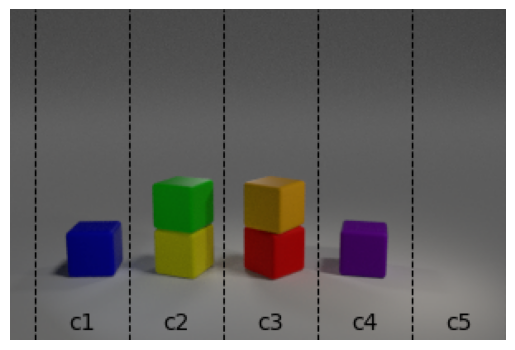

Q: Is the purple block the topmost of its column?, A: yes, Yes: 0.78, No: 0.22
Q: Is the purple block in the column labeled "c1"?, A: no, Yes: 0.00, No: 1.00
--------------------------------------------------------------------------------
Q: Is the purple block in the column labeled "c1"?, A: yes, Yes: 0.99, No: 0.00
Q: Is the purple block the topmost of its column?, A: yes, Yes: 0.97, No: 0.03
Q: Is the purple block in the column labeled "c4"?, A: no, Yes: 0.00, No: 1.00
Q: Is the purple block on top of the blue block?, A: yes, Yes: 0.99, No: 0.01
Q: Is the blue block the topmost of its column?, A: no, Yes: 0.20, No: 0.79
VLM state changed after effects: ['incolumn p,c1 to True', 'incolumn p,c4 to False', 'on p,b to True', 'clear b to False']
After action moveblock(p, c1)


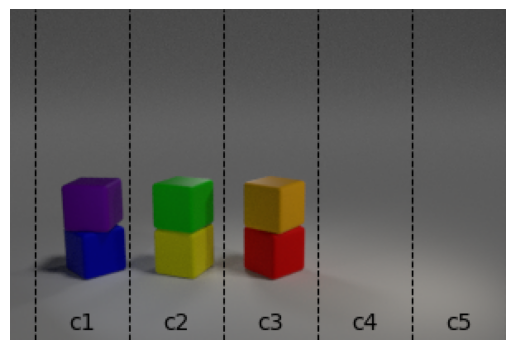

Applying action moveblock(g, c5)
Before action moveblock(g, c5)


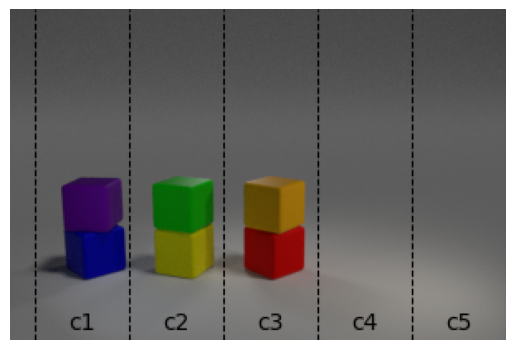

Q: Is the green block the topmost of its column?, A: yes, Yes: 0.65, No: 0.35
Q: Is the green block in the column labeled "c5"?, A: no, Yes: 0.00, No: 1.00
--------------------------------------------------------------------------------
Q: Is the green block in the column labeled "c5"?, A: yes, Yes: 1.00, No: 0.00
Q: Is the green block the topmost of its column?, A: yes, Yes: 0.53, No: 0.47
Q: Is the green block in the column labeled "c2"?, A: no, Yes: 0.00, No: 1.00
Q: Is the green block on top of the yellow block?, A: no, Yes: 0.01, No: 0.99
Q: Is the yellow block the topmost of its column?, A: yes, Yes: 0.78, No: 0.22
VLM state changed after effects: ['incolumn g,c5 to True', 'incolumn g,c2 to False', 'on g,y to False', 'clear y to True']
After action moveblock(g, c5)


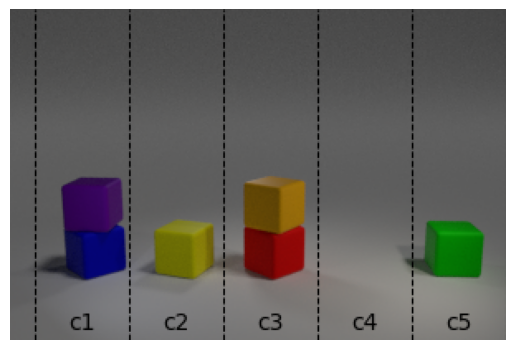

Applying action moveblock(y, c4)
Before action moveblock(y, c4)


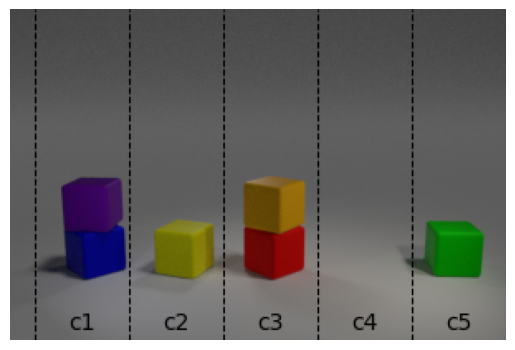

Q: Is the yellow block the topmost of its column?, A: yes, Yes: 0.78, No: 0.22
Q: Is the yellow block in the column labeled "c4"?, A: no, Yes: 0.00, No: 1.00
--------------------------------------------------------------------------------
Q: Is the yellow block in the column labeled "c4"?, A: yes, Yes: 1.00, No: 0.00
Q: Is the yellow block the topmost of its column?, A: yes, Yes: 0.82, No: 0.18
Q: Is the yellow block in the column labeled "c2"?, A: no, Yes: 0.00, No: 1.00
VLM state changed after effects: ['incolumn y,c4 to True', 'incolumn y,c2 to False']
After action moveblock(y, c4)


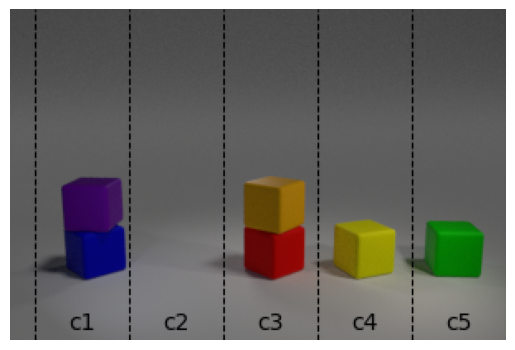

Applying action moveblock(p, c4)
Before action moveblock(p, c4)


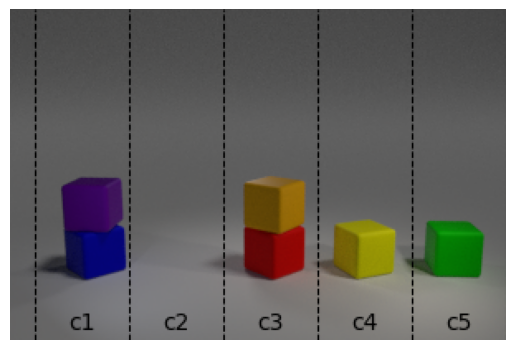

Q: Is the purple block the topmost of its column?, A: yes, Yes: 0.98, No: 0.02
Q: Is the purple block in the column labeled "c4"?, A: no, Yes: 0.00, No: 1.00
--------------------------------------------------------------------------------
Q: Is the purple block in the column labeled "c4"?, A: yes, Yes: 0.98, No: 0.02
Q: Is the purple block the topmost of its column?, A: yes, Yes: 0.80, No: 0.20
Q: Is the purple block in the column labeled "c1"?, A: no, Yes: 0.00, No: 1.00
Q: Is the purple block on top of the blue block?, A: no, Yes: 0.02, No: 0.98
Q: Is the blue block the topmost of its column?, A: yes, Yes: 0.94, No: 0.06
Q: Is the purple block on top of the yellow block?, A: yes, Yes: 0.96, No: 0.04
Q: Is the yellow block the topmost of its column?, A: yes, Yes: 0.62, No: 0.38
VLM state changed after effects: ['incolumn p,c4 to True', 'incolumn p,c1 to False', 'on p,b to False', 'clear b to True', 'on p,y to True']
After action moveblock(p, c4)


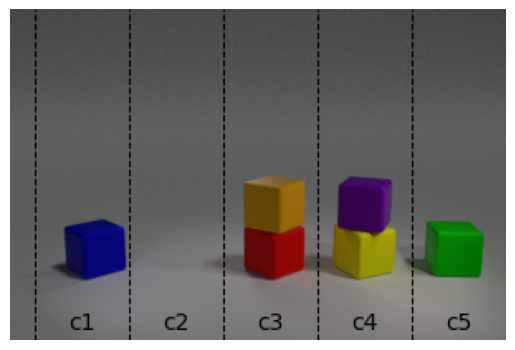

Action moveblock(p, c4) failed: Not all effects were observed as expected
Failed question: clear y, Answer: yes, Yes: 0.62, No: 0.38
Replanning...
  *** Credits ***
  * In operation mode `OneshotPlanner` at line 2 of `/tmp/ipykernel_1292242/4045684655.py`, you are using the following planning engine:
  * Engine name: Fast Downward
  * Developers:  Uni Basel team and contributors (cf. https://github.com/aibasel/downward/blob/main/README.md)
  * Description: Fast Downward is a domain-independent classical planning system.

Fast Downward returned: SequentialPlan:
    moveblock(o, c2)
    moveblock(r, c1)
    moveblock(r, c5)
    moveblock(b, c3)
    moveblock(r, c1)
Applying action moveblock(o, c2)
Before action moveblock(o, c2)


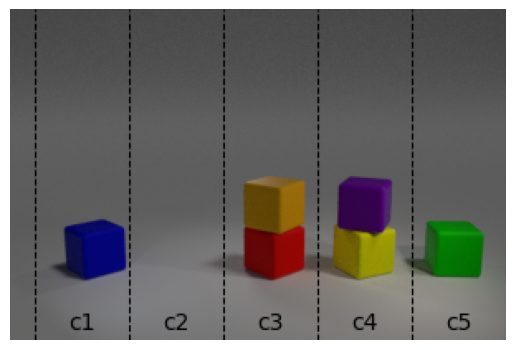

Q: Is the orange block the topmost of its column?, A: no, Yes: 0.29, No: 0.70
Q: Is the orange block in the column labeled "c2"?, A: no, Yes: 0.00, No: 1.00
VLM state changed after preconditions: ['clear o to False']
Preconditions not satisfied
After action moveblock(o, c2)


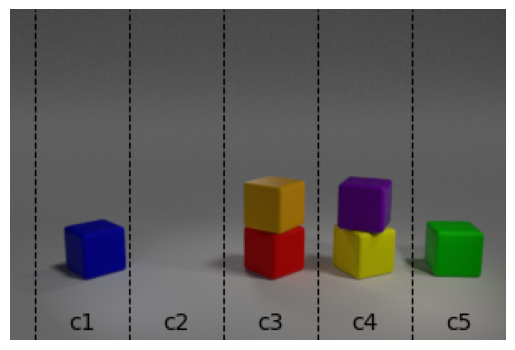

Action moveblock(o, c2) failed: Preconditions not satisfied
Failed question: clear o, Answer: no, Yes: 0.29, No: 0.70
Replanning...
  *** Credits ***
  * In operation mode `OneshotPlanner` at line 2 of `/tmp/ipykernel_1292242/4045684655.py`, you are using the following planning engine:
  * Engine name: Fast Downward
  * Developers:  Uni Basel team and contributors (cf. https://github.com/aibasel/downward/blob/main/README.md)
  * Description: Fast Downward is a domain-independent classical planning system.

No plan found.


(False,
 [(moveblock(p, c1),
   True,
   {'clear p': ('yes',
     0.7760549187660217,
     0.22234345972537994,
     None,
     True,
     'Yes'),
    'incolumn p,c1': ('no',
     1.6686690287315287e-05,
     0.9991012811660767,
     None,
     True,
     'No'),
    'all_correct': True},
   {'incolumn p,c1': ('yes',
     0.9947232007980347,
     0.004606482572853565,
     None,
     True,
     'Yes'),
    'clear p': ('yes',
     0.9694308042526245,
     0.02927427366375923,
     None,
     True,
     'Yes'),
    'incolumn p,c4': ('no',
     7.883896614657715e-06,
     0.9993120431900024,
     None,
     True,
     'No'),
    'on p,b': ('yes',
     0.9891392588615417,
     0.008557731285691261,
     None,
     True,
     'Yes'),
    'clear b': ('no',
     0.2008238583803177,
     0.7942737936973572,
     None,
     True,
     'No'),
    'all_correct': True}),
  (moveblock(g, c5),
   True,
   {'clear g': ('yes',
     0.6495839357376099,
     0.3476972281932831,
     None,
     True,
    

In [38]:
env.reset()
state = copy.deepcopy(env.state)
vlm_state = copy.deepcopy(env.state)

check_plan(env, result.plan, state, vlm_state, vlm, base_prompt, render=True, replan=True)